In [237]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [238]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [239]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [240]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [241]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [242]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [243]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [244]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [245]:
# Find the most recent date in the data set.
latest_dt=session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
latest_dt

'2017-08-23'

<Axes: xlabel='Date', ylabel='Inches'>

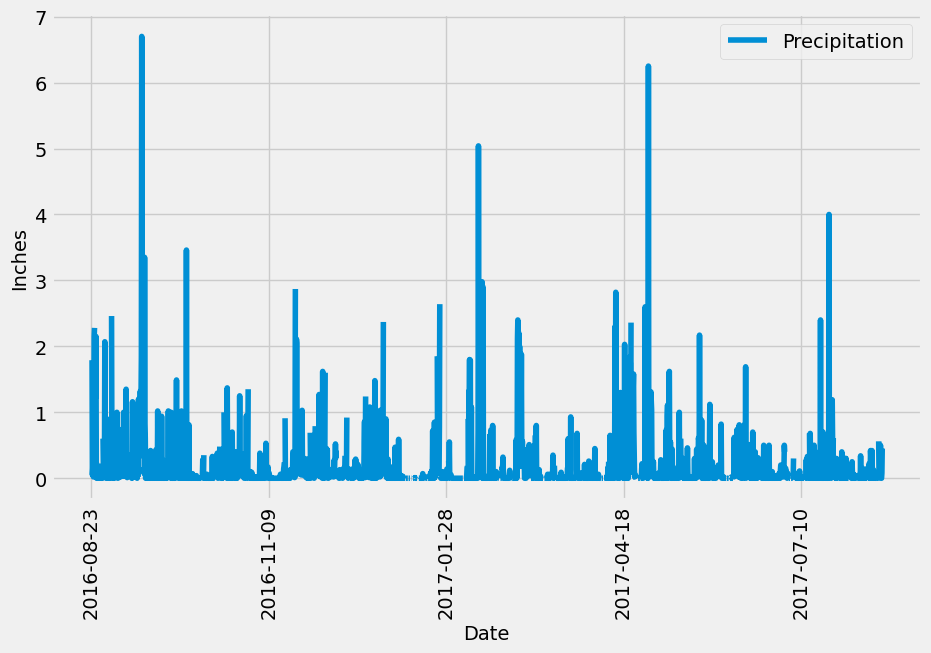

In [246]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# https://stackoverflow.com/questions/19480028/attributeerror-datetime-module-has-no-attribute-strptime
latest_date = dt.datetime.strptime(latest_dt, '%Y-%m-%d').date()
latest_date
# Calculate the date one year from the last date in data set.
lastyear_dt = latest_date - dt.timedelta(days=365)
lastyear_dt

# Perform a query to retrieve the data and precipitation scores
prcp_yr= session.query(measurement.date,measurement.prcp).filter(measurement.date>=lastyear_dt).all()
prcp_yr_list = [{"Date": p[0], "Precipitation": p[1]} for p in prcp_yr]
prcp_yr_list

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_yr_df = pd.DataFrame(prcp_yr_list,columns=['Date','Precipitation']).set_index('Date')
prcp_yr_df

# Sort the dataframe by date
prcp_yr_df.sort_index(ascending=True,inplace=True)
prcp_yr_df

# Use Pandas Plotting with Matplotlib to plot the data

prcp_plot =prcp_yr_df.plot(rot=90,ylabel="Inches",xlabel="Date",figsize=(10,6))
prcp_plot


In [247]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_yr_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [248]:
# Design a query to calculate the total number of stations in the dataset
station_cnt = session.query(func.count(station.station)).first()[0]
station_cnt


9

In [249]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station,func.count(measurement.station)).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
active_stations

# USC00519281 has the most number of observations 2772

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [250]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
most_active_station

most_active_temp=session.query(measurement.station,func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs))\
    .filter(measurement.station==most_active_station).first()
most_active_temp

('USC00519281', 54.0, 85.0, 71.66378066378067)

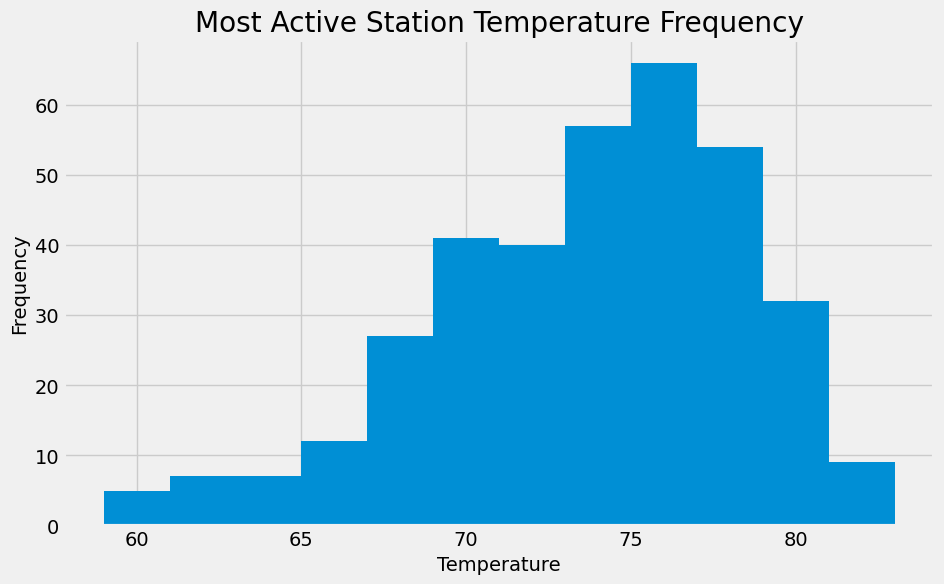

In [251]:
# Find the most recent date in the data set for one station.
ma_latest_dt=session.query(measurement.date).filter(measurement.station==most_active_station).order_by(measurement.date.desc()).first()[0]
ma_latest_dt

ma_latest_date = dt.datetime.strptime(ma_latest_dt, '%Y-%m-%d').date()
ma_latest_date

# Calculate the date one year from the last date in data set.
ma_lastyear_dt = ma_latest_date - dt.timedelta(days=365)
ma_lastyear_dt

# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_temp=session.query(measurement.tobs)\
    .filter(measurement.station==most_active_station)\
        .filter(measurement.date>=ma_lastyear_dt).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
most_active_temp_df = pd.DataFrame(most_active_temp,columns=['Temperature'])
most_active_temp_df

# Use Pandas Plotting with Matplotlib to plot the data
most_active_temp_plot =most_active_temp_df.hist(bins=12,figsize=(10,6))

# https://mode.com/example-gallery/python_histogram/
ax = most_active_temp_plot[0]
for x in ax:    
    x.set_title("Most Active Station Temperature Frequency")
    x.set_ylabel("Frequency")
    x.set_xlabel("Temperature")



# Close Session

In [252]:
# Close Session
session.close()